# 3. refinement 

In this notebook, we are refining cell profiles by removing treatment-cluster combinations with insufficient cell counts. This preprocessing step ensures robust statistical analysis by filtering out sparse clusters that may not provide reliable morphological signatures.

The refinement process involves:
1. **Loading clustered profiles**: Import pre-clustered single-cell morphological profiles from CFRET and Mitocheck datasets
2. **Analyzing cell count distributions**: Visualize the distribution of cells per treatment-cluster combination to identify outliers
3. **Setting filtering thresholds**: Use percentile-based cutoffs to determine minimum viable cluster sizes
4. **Applying refinement filters**: Remove treatment-cluster combinations below the threshold to create refined datasets suitable for phenotypic activity analysis

This refinement ensures that downstream Earth Mover's Distance [(EMD)](https://ieeexplore.ieee.org/document/710701) calculations are performed on sufficiently populated cell clusters, improving the reliability of morphological similarity measurements.

In [1]:
import sys
import pathlib

import numpy as np
import polars as pl
import matplotlib.pyplot as plt

sys.path.append("../../")
from utils import io_utils
from utils.refinement import get_cell_counts_per_cluster, refine_profiles

 Setting parameters for the notebook

In [2]:
cfret_treatment_col = "Metadata_treatment"
mitocheck_treatment_col = "Metadata_Gene"
cluster_col = "Metadata_cluster"
percentile_cutoff = 20

Setting input and output paths

In [3]:
# setting directories
data_dir = pathlib.Path("../0.download-data/data/sc-profiles").resolve(strict=True)
results_dir = pathlib.Path("./results").resolve(
    strict=True
)  # change dirname from _results to results
cluster_labels_dir = (results_dir / "cluster-labels").resolve(strict=True)

# setting cfret1 profile paths, signatures, cluster labels
cfret_profiles_path = (
    data_dir / "cfret" / "localhost230405150001_sc_feature_selected.parquet"
).resolve(strict=True)
cfret_cluster_labels_path = (cluster_labels_dir / "cfret_cluster_results.pkl").resolve(
    strict=True
)

# setting mitocheck profile paths, signatures, cluster labels
mitocheck_negcon_profiles_path = (
    data_dir / "mitocheck" / "negcon_mitocheck_cp_profiles.parquet"
).resolve(strict=True)
mitocheck_trt_profiles_path = (
    data_dir / "mitocheck" / "treated_mitocheck_cp_profiles.parquet"
).resolve(strict=True)
mitocheck_cluster_labels_path = (
    cluster_labels_dir / "mitocheck_cluster_results.pkl"
).resolve(strict=True)

# setting output directory
refined_profiles_dir = (results_dir / "refined-profiles").resolve()
refined_profiles_dir.mkdir(exist_ok=True)

loading profiles and splitting them between negative controls and treated profiles

In [4]:
# load cfret profiles
cfret_profiles = pl.read_parquet(cfret_profiles_path)
negcon_cfret_profiles = cfret_profiles.filter(pl.col("Metadata_treatment") == "DMSO")
treated_cfret_profiles = cfret_profiles.filter(pl.col("Metadata_treatment") != "DMSO")

# load mitocheck
mitocheck_negcon_profiles = pl.read_parquet(mitocheck_negcon_profiles_path)
mitocheck_trt_profiles = pl.read_parquet(mitocheck_trt_profiles_path)

# load cluster labels (pickle files)
mitocheck_cluster_labels = io_utils.load_configs(mitocheck_cluster_labels_path)
cfret_cluster_labels = io_utils.load_configs(cfret_cluster_labels_path)

adding cluster labels to the treated profiles

In [5]:
mitocheck_trt_profiles = mitocheck_trt_profiles.with_columns(
    pl.Series("Metadata_cluster", mitocheck_cluster_labels["cluster_labels"])
)
treated_cfret_profiles = treated_cfret_profiles.with_columns(
    pl.Series("Metadata_cluster", cfret_cluster_labels["cluster_labels"])
)

Visualizing the amount of cluster that will be dropped after refinement

In [6]:
# group by treatment  and cluster label, count cells per group
mitocheck_cell_counts_per_cluster = get_cell_counts_per_cluster(
    mitocheck_trt_profiles,
    treatment_col="Metadata_Gene",
    cluster_col="Metadata_cluster",
)

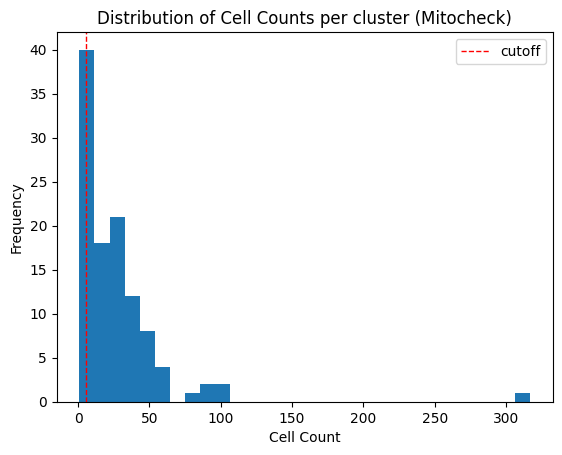

In [7]:
# create a histogram
plt.hist(mitocheck_cell_counts_per_cluster, bins=30)
plt.axvline(
    np.percentile(mitocheck_cell_counts_per_cluster, percentile_cutoff),
    color="r",
    linestyle="dashed",
    linewidth=1,
    label="cutoff",
)
plt.xlabel("Cell Count")
plt.ylabel("Frequency")
plt.title("Distribution of Cell Counts per cluster (Mitocheck)")
plt.legend()
plt.savefig(
    refined_profiles_dir / "mitocheck_cell_counts_distribution.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [8]:
cfret_cell_counts_per_cluster = get_cell_counts_per_cluster(
    treated_cfret_profiles,
    treatment_col="Metadata_treatment",
    cluster_col="Metadata_cluster",
)

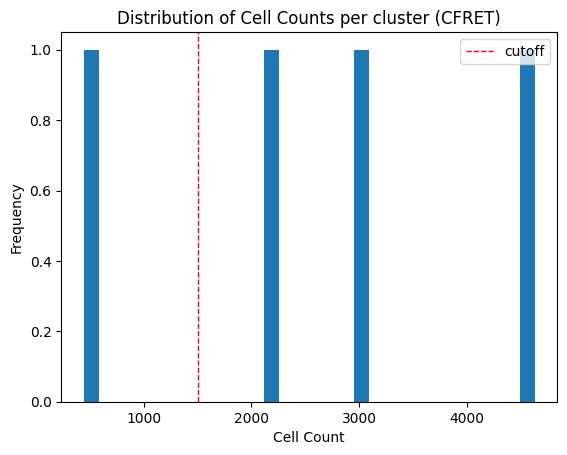

In [9]:
# create a histogram
plt.hist(cfret_cell_counts_per_cluster, bins=30)
plt.axvline(
    np.percentile(cfret_cell_counts_per_cluster, percentile_cutoff),
    color="r",
    linestyle="dashed",
    linewidth=1,
    label="cutoff",
)
plt.xlabel("Cell Count")
plt.ylabel("Frequency")
plt.title("Distribution of Cell Counts per cluster (CFRET)")
plt.legend()
plt.savefig(
    refined_profiles_dir / "cfret_cell_counts_distribution.png",
    dpi=300,
    bbox_inches="tight",
)

## Refine profiles



In [10]:
refined_mitocheck_trt_profiles = refine_profiles(
    profile=mitocheck_trt_profiles,
    treatment_col=mitocheck_treatment_col,
    cluster_col=cluster_col,
    percentile_cutoff=percentile_cutoff,
    method="cluster_cellcounts",
)

refined_cfret_trt_profiles = refine_profiles(
    profile=treated_cfret_profiles,
    treatment_col=cfret_treatment_col,
    cluster_col=cluster_col,
    percentile_cutoff=percentile_cutoff,
    method="cluster_cellcounts",
)

In [11]:
# save profiles to results/refined directory
refined_cfret_trt_profiles.write_parquet(
    refined_profiles_dir / "refined_cfret_trt_profiles.parquet"
)
refined_mitocheck_trt_profiles.write_parquet(
    refined_profiles_dir / "refined_mitocheck_trt_profiles.parquet"
)